# Import

In [1]:
%matplotlib inline

import os
import math
from pathlib import Path
from functools import partial
from inspect import isfunction

import cv2
import matplotlib
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from einops.layers.torch import Rearrange
from einops import rearrange, reduce, repeat
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import torch
import torchvision
from torch import nn, einsum
import torch.utils.data as data
import torch.nn.functional as F
from torchvision import transforms
from torch.cuda.amp import autocast
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize

from utils import *
from unet import Unet
from data_loader import make_data_loader

# Parameters

In [34]:
device = 'cuda'
image_size = 64
batch_size = 128

# model_path = 'weight/log3_C26_S100_cfg_step_400000.pth' # disentangle loss なし, 100font
# model_path = 'weight/log7_C26_S1000_cfg_step_final.pth' #
# model_path = 'weight/log8_C26_S1000_cfg_step_90000.pth' # 両方Φにならないように, (c, s) = (c, Φ) + (Φ, s)
model_path = 'weight/log9_C26_S1000_cfg_step_final.pth' #  (c, s) = {(c, Φ) + (Φ, s)}/2
# model_path = './weight/log12_C26_S1000_cfg_step_final.pth' # disentangle loss バグ修正, (c, s) = {(c, Φ) + (Φ, s)}/√2, step:1e5
# model_path = './weight/log13_C26_S1000_cfg_step_final.pth' # disentangle loss バグ修正, (c, s) = {(c, Φ) + (Φ, s)}/√2, step:5e5
# model_path = './weight/log14_C26_S1000_cfg_step_final.pth' # disentangle loss なし, 1000font
channels = 1
unet_dim = 32
timesteps = 1000
cond_drop_prob = 0.5
unet_dim_mults = (1, 2, 4, 8,)
num_style = int(model_path.split('/')[-1].split('_')[2][1:])
num_classes = int(model_path.split('/')[-1].split('_')[1][1:])

# define betas
betas = cosine_beta_schedule(timesteps=timesteps)

# define alphas
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0) # alpha_var
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0) # [1. , *alphas_cumpprod[:-1]]
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
# 順方向の拡散過程
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod) # どのくらい元画像を残すか，徐々に小さくなる
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod) # どのくらいノイズを加えるか，徐々に大きくなる

# calculations for posterior q(x_{t-1} | x_t, x_0)
# 逆方向の拡散過程
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod) # sigma_t^2 どのくらいノイズを加えるか，徐々に小さくなる．非常に小さい

# forward diffusion (using the nice property)
@autocast(enabled = False)
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x_start.shape)

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

@torch.no_grad()
def p_sample(model, x, classes, style, t, t_index, class_scale=6., style_scale=6., rescaled_phi=0.7):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    pred_noise = model.forward_with_cond_scale(x, t, classes, style, class_scale=class_scale, style_scale=style_scale, rescaled_phi=rescaled_phi)
    model_mean = sqrt_recip_alphas_t * (x - betas_t * pred_noise / sqrt_one_minus_alphas_cumprod_t)

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise

# Algorithm 2 (including returning all images)
@torch.no_grad()
def p_sample_loop(model, classes, style, shape, class_scale=6., style_scale=6., rescaled_phi=0.7):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, classes, style, torch.full((b,), i, device=device, dtype=torch.long), i, class_scale=class_scale, style_scale=style_scale, rescaled_phi=rescaled_phi)
    return img

@torch.no_grad()
def sample(model, classes, style, image_size, batch_size=16, channels=3, class_scale=6., style_scale=6., rescaled_phi=0.7):
    return p_sample_loop(model, classes, style, shape=(batch_size, channels, image_size, image_size), class_scale=class_scale, style_scale=style_scale, rescaled_phi=rescaled_phi)

def imscatter(x,y,image_list,_ax=None,zoom=0.2,color=['black']):
    for i in range(len(image_list)):
        if len(color) < len(image_list):
            color.append(color[0])
        if _ax is None:
            _ax = plt.gca()
        image = image_list[i] #plt.imread(image_list[i])
        im = OffsetImage(image,zoom=zoom)
        artists = []
        x0 = x[i]
        y0 = y[i]
        ab = AnnotationBbox(im,(x0,y0),xycoords='data',frameon=True,bboxprops=dict(color=color[i]))
        artists.append(_ax.add_artist(ab))
    return artists

# データの読み込み

In [3]:
dataloader = make_data_loader(batch_size, image_size, num_style)['train']
d = dataloader.dataset

TRAIN SIZE: 26000
TEST SIZE: 0


In [ ]:
i = 26*4 + 23
d = dataloader.dataset
plt.imshow(d[i][0][0], cmap='gray')
c = chr(d[i][1] + ord('A'))
print(c)
print('style:', d[i][2])
print(d[i][0][0].min(), d[i][0][0].max())

In [ ]:
max_i = 0
for _, _, i in d['train'].dataset:
    max_i = max(max_i, i)
print(max_i)

# Load trained model

In [35]:
model = Unet(
    dim=unet_dim,
    channels=channels,
    dim_mults=unet_dim_mults,
    num_classes=num_classes,
    num_style=num_style,
    cond_drop_prob=cond_drop_prob,
)
model.to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print(f'ok {model_path}')

ok weight/log9_C26_S1000_cfg_step_final.pth


# 生成画像のL1

In [ ]:
with open('result/eval.txt', 'a') as f:
    f.write('\n============\n')
    f.write(f"{model_path.split('/')[-1]}\n")

for scale in [3., 5., 7.]:
    style_scale = scale
    class_scale = scale
    rescaled_phi = 0.7

    loss = nn.L1Loss()
    total_loss = 0.

    for gt, c, s in dataloader:
        gt = gt.to(device)
        c = c.to(device)
        s = s.to(device)
        output = sample(model, c, s, image_size=image_size, batch_size=gt.size(0), channels=channels,
                        class_scale=class_scale, style_scale=style_scale, rescaled_phi=rescaled_phi)

        total_loss += loss(output, gt).item() * gt.size(0)

    total_loss /= len(dataloader.dataset)

    # eval.txt は全モデルで共通
    with open('result/eval.txt', 'a') as f:
        f.write(f'\tscale: {scale}, l1 loss: {total_loss}\n')

# condition指定して生成

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

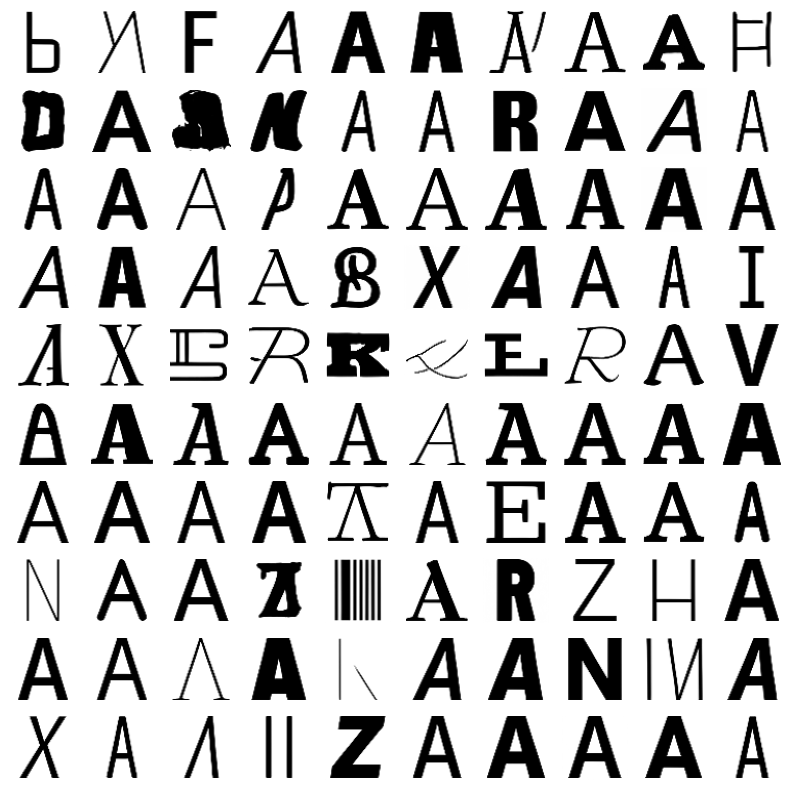

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

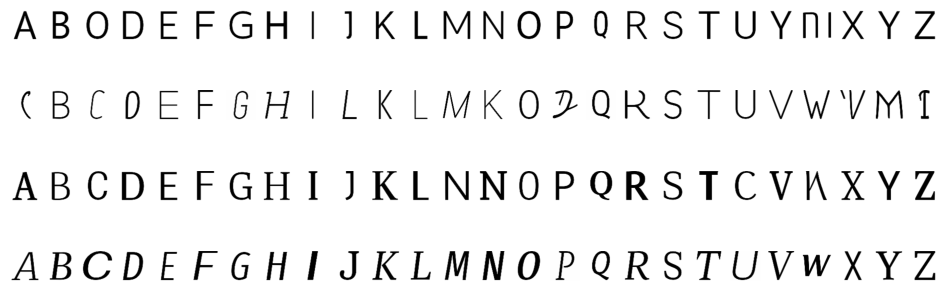

In [167]:
style_scale = 1.
class_scale = 1.
rescaled_phi = 0.7
save_path1 = f"result/{os.path.basename(model_path).split('.')[0]}_generated1_sc+[sc-s÷√2]+[sc-c÷√2]_{style_scale}_{class_scale}.png"
save_path2 = f"result/{os.path.basename(model_path).split('.')[0]}_generated2_sc+[sc-s÷√2]+[sc-c÷√2]_{style_scale}_{class_scale}.png"
# 様々なスタイルを見る
b = 100
classes = torch.full((b,), 0, device=device, dtype=torch.long)
style = torch.tensor([i for i in range(b)], device=device, dtype=torch.long)
samples = sample(model, classes, style, image_size=image_size, batch_size=b, channels=channels, class_scale=class_scale, style_scale=style_scale, rescaled_phi=rescaled_phi)

# show images
fig, ax = plt.subplots(10, 10, figsize=(10, 10))
for i in range(b):
    x = i // 10
    y = i % 10
    ax[x, y].axis("off")
    ax[x, y].imshow(samples[i][0].cpu().detach(), cmap="gray")

plt.savefig(save_path1)
plt.show()

# 様々なクラスを見る
b = 26*4
classes = torch.tensor([i%26 for i in range(b)], device=device, dtype=torch.long)
style = torch.tensor([i//26 for i in range(b)], device=device, dtype=torch.long)
samples = sample(model, classes, style, image_size=image_size, batch_size=b, channels=channels, class_scale=class_scale, style_scale=style_scale, rescaled_phi=rescaled_phi)

# show images
fig, ax = plt.subplots(4, 26, figsize=(12, 4))
for i in range(b):
    x = i // 26
    y = i % 26
    ax[x, y].axis("off")
    ax[x, y].imshow(samples[i][0].cpu().detach(), cmap="gray")

plt.savefig(save_path2)
plt.show()

# GT

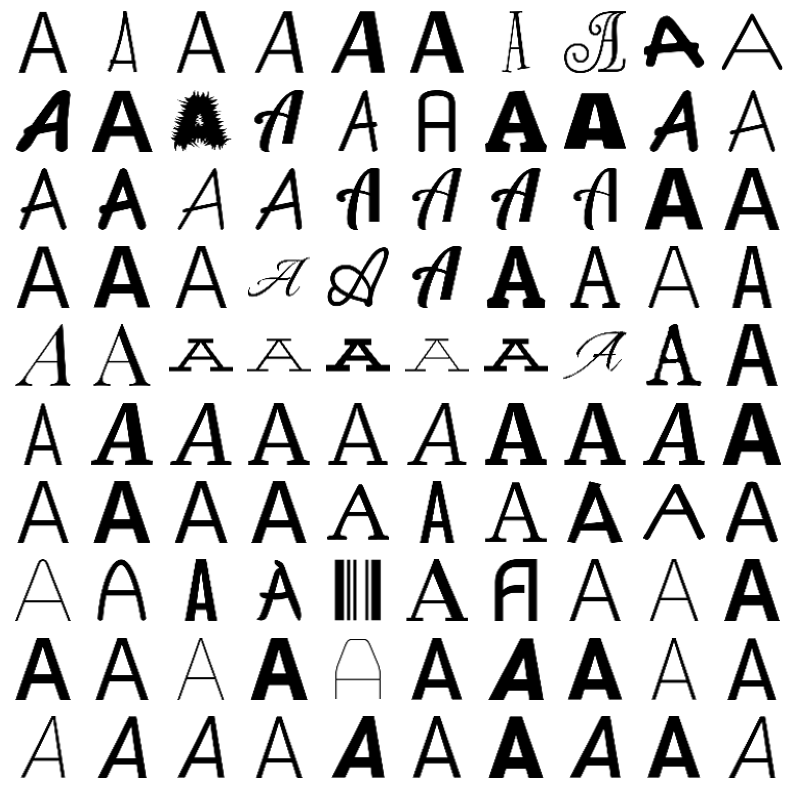

In [7]:
# 100フォント見る（上から100）
fig, ax = plt.subplots(10, 10, figsize=(10, 10))
for i in range(100):
    ax[i//10, i%10].axis('off')
    ax[i//10, i%10].imshow(d[26*i][0][0], cmap='gray')

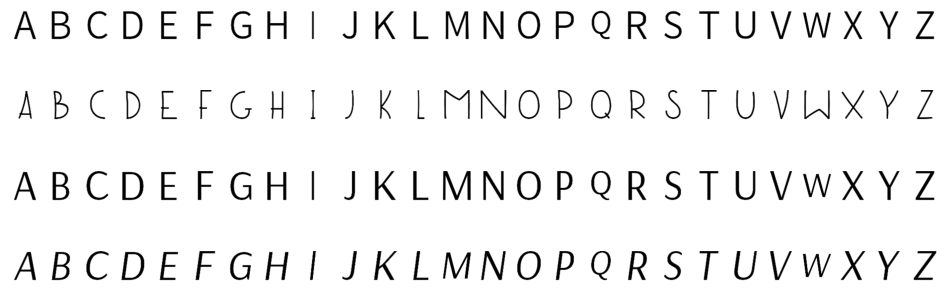

In [5]:
# 上から4フォント，A-Z
fig, ax = plt.subplots(4, 26, figsize=(12, 4))
for i in range(4*26):
    ax[i//26, i%26].axis('off')
    ax[i//26, i%26].imshow(d[i][0][0], cmap='gray')

# ノイズのインターポレーション

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

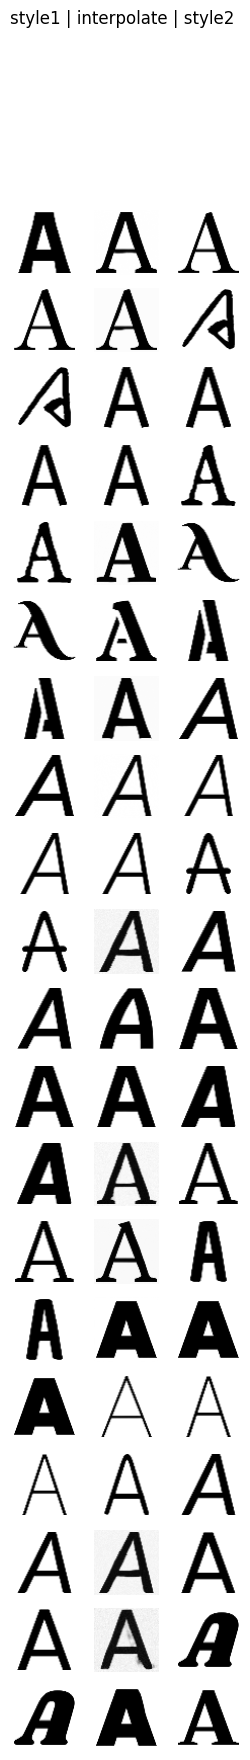

In [22]:
@torch.no_grad()
def p_sample_noise_interpolate(x, classes, style1, style2, t, t_index, class_scale=6., style_scale=6., rescaled_phi=0.7):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    pred_noise1 = model.forward_with_cond_scale(x, t, classes, style1, class_scale=class_scale, style_scale=style_scale, rescaled_phi=rescaled_phi)
    pred_noise2 = model.forward_with_cond_scale(x, t, classes, style2, class_scale=class_scale, style_scale=style_scale, rescaled_phi=rescaled_phi)
    alpha = 0.5
    pred_noise = alpha * pred_noise1 + (1 - alpha) * pred_noise2
    model_mean = sqrt_recip_alphas_t * (x - betas_t * pred_noise / sqrt_one_minus_alphas_cumprod_t)

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

style_scale = 3.
class_scale = 3.
rescaled_phi = 0.7

b = 20
img = torch.randn((b, channels, image_size, image_size), device=device)
classes = torch.full((b,), 0, device=device, dtype=torch.long)
style = torch.tensor([[i, (i+1)%num_style] for i in range(b)], device=device, dtype=torch.long)

for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
    img = p_sample_noise_interpolate(img, classes, style[:, 0], style[:, 1], torch.full((b,), i, device=device, dtype=torch.long), i,
                    class_scale=class_scale, style_scale=style_scale, rescaled_phi=rescaled_phi)

fig, ax = plt.subplots(b, 3, figsize=(3, b))
for i in range(b):
    ax[i, 0].axis('off')
    ax[i, 1].axis('off')
    ax[i, 2].axis('off')
    ax[i, 0].imshow(d[26*style[i][0]][0][0], cmap='gray')
    ax[i, 1].imshow(img[i][0].cpu().detach().clone(), cmap='gray')
    ax[i, 2].imshow(d[26*style[i][1]][0][0], cmap='gray')
fig.suptitle('style1 | interpolate | style2')
plt.savefig(f"result/{os.path.basename(model_path).split('.')[0]}_noise_interpolate_{style_scale}_{class_scale}.png")

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

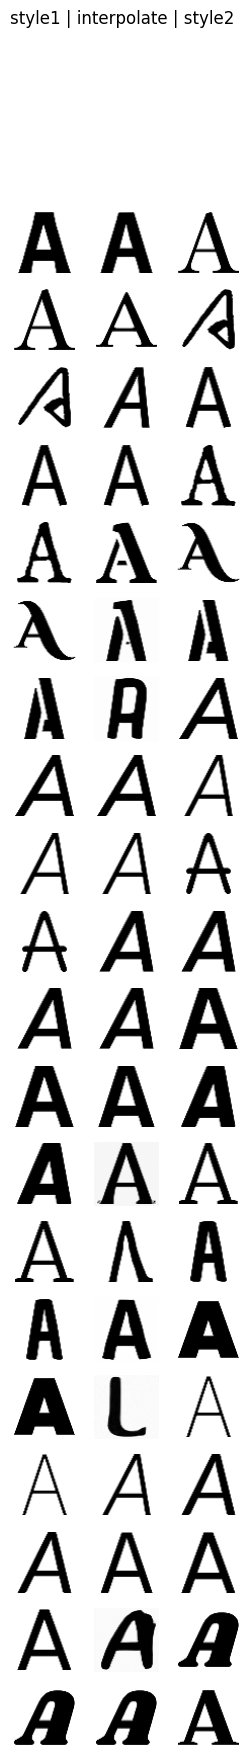

In [11]:
@torch.no_grad()
def p_sample_interpolate(x, classes, style1, style2, t, t_index, class_scale=6., style_scale=6., rescaled_phi=0.7):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    style1_noise = model(x, t, classes, style1, class_drop_prob=0., style_drop_prob=0.)
    style2_noise = model(x, t, classes, style2, class_drop_prob=0., style_drop_prob=0.)
    style_null_noise = model(x, t, classes, style1, class_drop_prob=0., style_drop_prob=1.)

    alpha = 0.5
    scaled_noise = style_scale * (alpha*(style1_noise - style_null_noise) + (1-alpha)*(style2_noise - style_null_noise)) + style_null_noise

    std_fn = partial(torch.std, dim = tuple(range(1, scaled_noise.ndim)), keepdim = True)
    rescaled_noise = scaled_noise * (std_fn(style_null_noise) / std_fn(scaled_noise))

    model_mean = sqrt_recip_alphas_t * (x - betas_t * rescaled_noise / sqrt_one_minus_alphas_cumprod_t)

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

style_scale = 3.
class_scale = 3.
rescaled_phi = 0.7

b = 20
img = torch.randn((b, channels, image_size, image_size), device=device)
classes = torch.full((b,), 0, device=device, dtype=torch.long)
# style = torch.tensor([[random.randint(0, num_style-1), random.randint(0, num_style-1)] for i in range(b)], device=device, dtype=torch.long)
style = torch.tensor([[i, i+1] for i in range(b)], device=device, dtype=torch.long)

for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
    img = p_sample_interpolate(img, classes, style[:, 0], style[:, 1], torch.full((b,), i, device=device, dtype=torch.long), i,
                    class_scale=class_scale, style_scale=style_scale, rescaled_phi=rescaled_phi)

fig, ax = plt.subplots(b, 3, figsize=(3, b))
for i in range(b):
    ax[i, 0].axis('off')
    ax[i, 1].axis('off')
    ax[i, 2].axis('off')
    ax[i, 0].imshow(d[26*style[i][0]][0][0], cmap='gray')
    ax[i, 1].imshow(img[i][0].cpu().detach().clone(), cmap='gray')
    ax[i, 2].imshow(d[26*style[i][1]][0][0], cmap='gray')

fig.suptitle('style1 | interpolate | style2')
plt.savefig(f"result/{os.path.basename(model_path).split('.')[0]}_noise_interpolate2_{style_scale}_{class_scale}.png")

# 埋め込み表現のインターポレーション

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

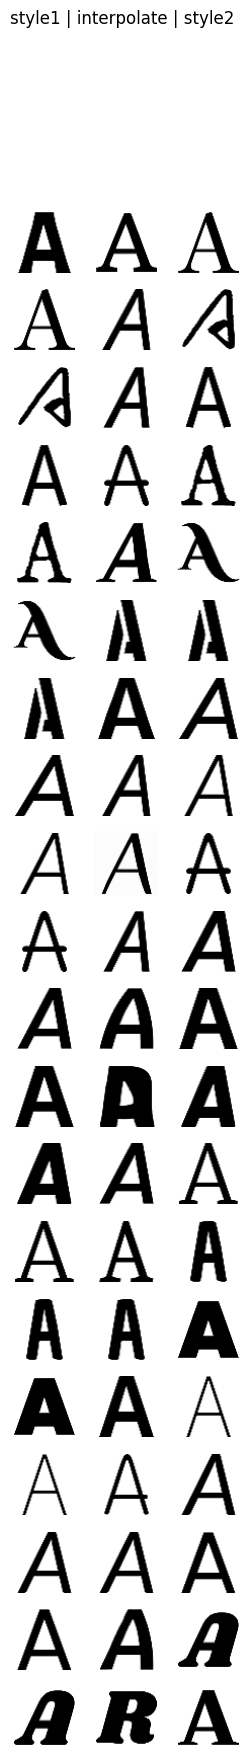

In [5]:
@torch.no_grad()
def p_sample_emb_interpolate(x, classes, style1, style2, t, t_index, class_scale=6., style_scale=6., rescaled_phi=0.7):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    pred_noise = model.emb_interpolate(x, t, classes, style1, style2, alpha=0.5)
    model_mean = sqrt_recip_alphas_t * (x - betas_t * pred_noise / sqrt_one_minus_alphas_cumprod_t)

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

style_scale = 3.
class_scale = 3.
rescaled_phi = 0.7

b = 20
img = torch.randn((b, channels, image_size, image_size), device=device)
classes = torch.full((b,), 0, device=device, dtype=torch.long)
style = torch.tensor([[i, (i+1)%num_style] for i in range(b)], device=device, dtype=torch.long)

for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
    img = p_sample_emb_interpolate(img, classes, style[:, 0], style[:, 1], torch.full((b,), i, device=device, dtype=torch.long), i,
                    class_scale=class_scale, style_scale=style_scale, rescaled_phi=rescaled_phi)

fig, ax = plt.subplots(b, 3, figsize=(3, b))
for i in range(b):
    ax[i, 0].axis('off')
    ax[i, 1].axis('off')
    ax[i, 2].axis('off')
    ax[i, 0].imshow(d[26*style[i][0]][0][0], cmap='gray')
    ax[i, 1].imshow(img[i][0].cpu().detach().clone(), cmap='gray')
    ax[i, 2].imshow(d[26*style[i][1]][0][0], cmap='gray')
fig.suptitle('style1 | interpolate | style2')
plt.savefig(f"result/{os.path.basename(model_path).split('.')[0]}_emb_interpolate_{style_scale}_{class_scale}.png")

# reconstruction

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

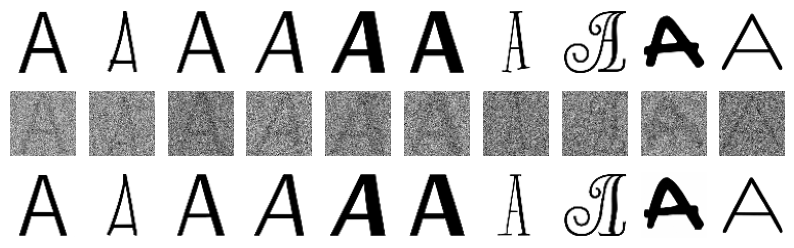

In [5]:
imgs = []
for i in range(10):
    imgs.append(d[26*i][0])
imgs = torch.stack(imgs).to(device)

sampling_t = int(0.8 * timesteps)
t = torch.full((10,), sampling_t, device=device, dtype=torch.long)
noisy_imgs = q_sample(imgs, t)

classes = torch.full((10,), 0, device=device, dtype=torch.long)
style = torch.tensor([i for i in range(10)], device=device, dtype=torch.long)
out = noisy_imgs
for i in tqdm(reversed(range(0, sampling_t)), desc='sampling loop time step', total=timesteps):
    out = p_sample(model, out, classes, style, torch.full((10,), i, device=device, dtype=torch.long), i,
                    class_scale=3., style_scale=3., rescaled_phi=.7)

fig, ax = plt.subplots(3, 10, figsize=(10, 3))
for i in range(imgs.shape[0]):
    ax[0, i].axis('off')
    ax[1, i].axis('off')
    ax[2, i].axis('off')
    ax[0, i].imshow(imgs[i][0].cpu().detach(), cmap='gray')
    ax[1, i].imshow(noisy_imgs[i][0].cpu().detach(), cmap='gray')
    ax[2, i].imshow(out[i][0].cpu().detach(), cmap='gray')

# ノイズの可視化

## style and class

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

ε(c, s) [0.00227416 0.00215917 0.00191331]


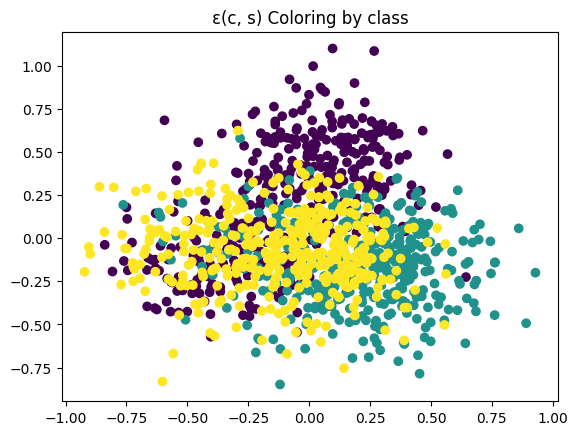

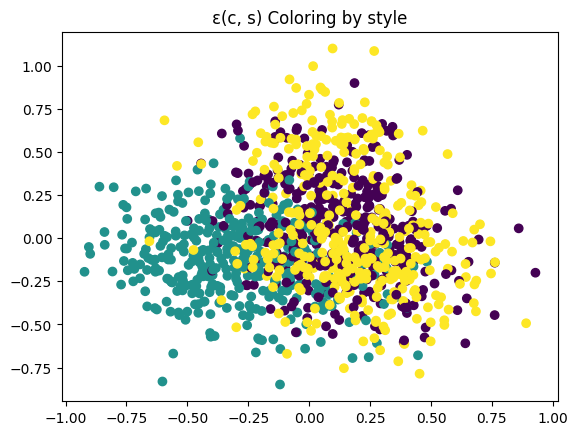

ε(c, Φ) [0.02736016 0.01703722 0.00314284]


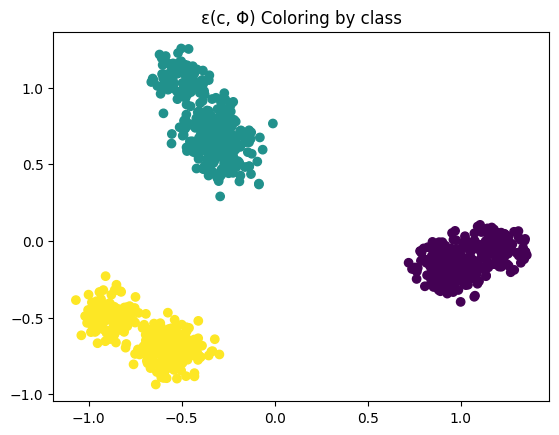

ε(Φ, s) [0.02757407 0.01724046 0.00293178]


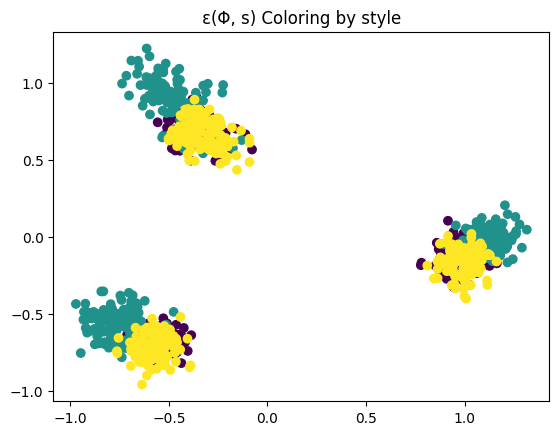

In [4]:
# 同じノイズからの各クラスのノイズの方向

style_scale = 3.
class_scale = 3.
rescaled_phi = .7
target_class_num = 3
target_style_num = 3
t_range = (int(0.90*timesteps), int(1.0*timesteps))
pca_path = f"./result/{os.path.basename(model_path).split('.')[0]}_C{target_class_num}_S{target_style_num}_styleclass1_PCA_time{t_range[0]}-{t_range[1]}.png"
pca_path2 = f"./result/{os.path.basename(model_path).split('.')[0]}_C{target_class_num}_S{target_style_num}_styleclass2_PCA_time{t_range[0]}-{t_range[1]}.png"
class_pca_path = f"./result/{os.path.basename(model_path).split('.')[0]}_C{target_class_num}_S{target_style_num}_class_PCA_time{t_range[0]}-{t_range[1]}.png"
style_pca_path = f"./result/{os.path.basename(model_path).split('.')[0]}_C{target_class_num}_S{target_style_num}_style_PCA_time{t_range[0]}-{t_range[1]}.png"

# 正規分布からノイズをサンプリング
noise_img = torch.randn_like(torch.zeros((1, 1, image_size, image_size)), device=device)

# # 実画像をノイズにしてサンプリング
# t = torch.full((1,), t_range[1]-1, device=device, dtype=torch.long)
# noise_img = q_sample(d[0][0].to(device), t).unsqueeze(0)

noise_img = torch.cat([noise_img for _ in range(128)], dim=0)
b = noise_img.shape[0]

noise_ave_list = [torch.zeros_like(noise_img).cpu().detach().clone() for _ in range(target_class_num*target_style_num)]
class_noise_ave_list = [torch.zeros_like(noise_img).cpu().detach().clone() for _ in range(target_class_num*target_style_num)]
style_noise_ave_list = [torch.zeros_like(noise_img).cpu().detach().clone() for _ in range(target_class_num*target_style_num)]
for c in range(target_class_num):
    for s in range(target_style_num):
        classes = torch.full((b,), c, device=device, dtype=torch.long)
        style = torch.full((b,), s, device=device, dtype=torch.long)
        x = noise_img
        with torch.no_grad():
            for i in tqdm(reversed(range(t_range[0], timesteps)), desc='sampling loop time step', total=timesteps): # 正規分布
            # for i in tqdm(reversed(range(t_range[0], t_range[1])), desc='sampling loop time step', total=timesteps): # 実画像
                t = torch.full((b,), i, device=device, dtype=torch.long)

                betas_t = extract(betas, t, x.shape)
                sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
                sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

                # ノイズ推定
                logits = model(x, t, classes, style, class_drop_prob=0., style_drop_prob=0.)
                class_null_logits = model(x, t, classes, style, class_drop_prob=1., style_drop_prob=0.)
                style_null_logits = model(x, t, classes, style, class_drop_prob=0., style_drop_prob=1.)

                # guidance
                ## disentangle cfg
                if i >= 900:
                    scaled_logits = logits + style_scale * class_null_logits + class_scale * style_null_logits
                else:
                    scaled_logits = logits + style_scale * (logits - style_null_logits) + class_scale * (logits - class_null_logits)

                # ## simple cfg
                # scaled_logits = logits + style_scale * (logits - style_null_logits) + class_scale * (logits - class_null_logits)

                # rescale
                std_fn = partial(torch.std, dim = tuple(range(1, scaled_logits.ndim)), keepdim = True)
                rescaled_logits = scaled_logits * (std_fn(logits) / std_fn(scaled_logits))
                pred_noise = rescaled_logits * rescaled_phi + scaled_logits * (1. - rescaled_phi)

                # x_{t-1}を推定
                model_mean = sqrt_recip_alphas_t * (x - betas_t * pred_noise / sqrt_one_minus_alphas_cumprod_t)

                if t_range[0] <= i < t_range[1]:
                    noise_ave_list[c*target_style_num+s] += logits.cpu().detach().clone()
                    class_noise_ave_list[c*target_style_num+s] += style_null_logits.cpu().detach().clone()
                    style_noise_ave_list[c*target_style_num+s] += class_null_logits.cpu().detach().clone()

                if i == 0:
                    x = model_mean
                else:
                    posterior_variance_t = extract(posterior_variance, t, x.shape)
                    noise = torch.randn_like(x)
                    x = model_mean + torch.sqrt(posterior_variance_t) * noise

            noise_ave_list[c*target_style_num+s] = noise_ave_list[c*target_style_num+s] / (t_range[1] - t_range[0])
            class_noise_ave_list[c*target_style_num+s] = class_noise_ave_list[c*target_style_num+s] / (t_range[1] - t_range[0])
            style_noise_ave_list[c*target_style_num+s] = style_noise_ave_list[c*target_style_num+s] / (t_range[1] - t_range[0])

# pca
## ε(c, s)
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(torch.cat(noise_ave_list, dim=0).reshape(b*target_class_num*target_style_num, -1).numpy())
print(f'ε(c, s) {pca.explained_variance_ratio_}')

## class ごとに色を変える
plt.title('ε(c, s) Coloring by class')
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=[i//(b*target_style_num) for i in range(len(X_reduced))])
plt.savefig(pca_path)
plt.show()

## style ごとに色を変える
plt.title('ε(c, s) Coloring by style')
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=[(i//b)%target_style_num for i in range(len(X_reduced))])
plt.savefig(pca_path2)
plt.show()


## ε(c, Φ)
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(torch.cat(class_noise_ave_list, dim=0).reshape(b*target_class_num*target_style_num, -1).numpy())
print(f'ε(c, Φ) {pca.explained_variance_ratio_}')

plt.title('ε(c, Φ) Coloring by class')
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=[i//(b*target_style_num) for i in range(len(X_reduced))])
plt.savefig(class_pca_path)
plt.show()

# ε(Φ, s)
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(torch.cat(style_noise_ave_list, dim=0).reshape(b*target_class_num*target_style_num, -1).numpy())
print(f'ε(Φ, s) {pca.explained_variance_ratio_}')

plt.title('ε(Φ, s) Coloring by style')
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=[(i//b)%target_style_num for i in range(len(X_reduced))])
plt.savefig(style_pca_path)
plt.show()

## style or class

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

[0.00206251 0.00181796 0.00178304]


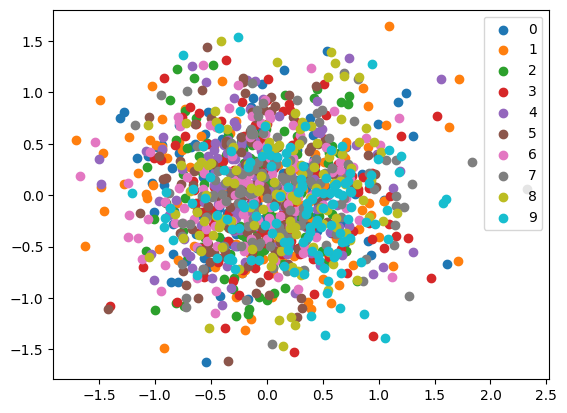

In [9]:
# 同じノイズからの各クラスのノイズの方向

style_scale = 3.
class_scale = 3.
rescaled_phi = .7
target_num = 10
noise_type_str = 'style' # 'style' or 'class'
t_range = (int(0.90*timesteps), int(1.0*timesteps))
# これをいじるとき，サンプリングのところもいじる
pca_path = f"./result/{os.path.basename(model_path).split('.')[0]}_{noise_type_str}_sc+c+s_PCA_time{t_range[0]}-{t_range[1]}.png"
# pca_path = f"./result/{os.path.basename(model_path).split('.')[0]}_{noise_type_str}_sc+[sc-s]+[sc-c]_PCA_time{t_range[0]}-{t_range[1]}.png"
# pca_path = f"./result/{os.path.basename(model_path).split('.')[0]}_{noise_type_str}_sc+[sc-s÷√2]+[sc-c÷√2]_PCA_time{t_range[0]}-{t_range[1]}.png"

# 正規分布からノイズをサンプリング
noise_img = torch.randn_like(torch.zeros((1, 1, image_size, image_size)), device=device)

# # 実画像をノイズにしてサンプリング
# t = torch.full((1,), t_range[1]-1, device=device, dtype=torch.long)
# noise_img = q_sample(d[0][0].to(device), t).unsqueeze(0)

noise_img = torch.cat([noise_img for _ in range(128)], dim=0)
b = noise_img.shape[0]

noise_ave_list = [torch.zeros_like(noise_img).cpu().detach().clone() for i in range(target_num)]
for clss in range(target_num):
    if noise_type_str == 'style':
        classes = torch.full((b,), 0, device=device, dtype=torch.long)
        style = torch.full((b,), clss, device=device, dtype=torch.long)
    elif noise_type_str == 'class':
        classes = torch.full((b,), clss, device=device, dtype=torch.long)
        style = torch.full((b,), 0, device=device, dtype=torch.long)
    else:
        raise ValueError(f'noise_type_str must be "style" or "class" but got {noise_type_str}')

    x = noise_img
    with torch.no_grad():
        for i in tqdm(reversed(range(t_range[0], timesteps)), desc='sampling loop time step', total=timesteps): # 正規分布
        # for i in tqdm(reversed(range(t_range[0], t_range[1])), desc='sampling loop time step', total=timesteps): # 実画像
            t = torch.full((b,), i, device=device, dtype=torch.long)

            betas_t = extract(betas, t, x.shape)
            sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
            sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

            # predict noise
            logits = model(x, t, classes, style, class_drop_prob=0., style_drop_prob=0.)
            style_null_logits = model(x, t, classes, style, class_drop_prob=0., style_drop_prob=1.)
            class_null_logits = model(x, t, classes, style, class_drop_prob=1., style_drop_prob=0.)

            scaled_logits = logits + style_scale * class_null_logits +  class_scale * style_null_logits
            # scaled_logits = logits + style_scale * (logits-style_null_logits) +  class_scale * (logits-class_null_logits)
            # scaled_logits = logits + style_scale * (logits-style_null_logits/math.sqrt(2)) +  class_scale * (logits-class_null_logits/math.sqrt(2))

            # rescale
            std_fn = partial(torch.std, dim = tuple(range(1, scaled_logits.ndim)), keepdim = True)
            rescaled_logits = scaled_logits * (std_fn(logits) / std_fn(scaled_logits))
            pred_noise = rescaled_logits * rescaled_phi + scaled_logits * (1. - rescaled_phi)

            # x_{t-1} を推定
            model_mean = sqrt_recip_alphas_t * (x - betas_t * pred_noise / sqrt_one_minus_alphas_cumprod_t)

            if t_range[0] <= i < t_range[1]:
                if noise_type_str == 'style':
                    noise_ave_list[clss] += class_null_logits.cpu().detach().clone()
                elif noise_type_str == 'class':
                    noise_ave_list[clss] += style_null_logits.cpu().detach().clone()
                else:
                    raise ValueError(f'noise_type_str must be "style" or "class" but got {noise_type_str}')

            if i == 0:
                x = model_mean
            else:
                posterior_variance_t = extract(posterior_variance, t, x.shape)
                noise = torch.randn_like(x)
                # Algorithm 2 line 4:
                x = model_mean + torch.sqrt(posterior_variance_t) * noise

        noise_ave_list[clss] = noise_ave_list[clss] / (t_range[1] - t_range[0])

# pca
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(torch.cat(noise_ave_list, dim=0).reshape(b*target_num, -1).numpy())
print(pca.explained_variance_ratio_)
x = X_reduced[:,0]
y = X_reduced[:,1]

for i in range(0, len(X_reduced), b):
    plt.scatter(x[i:i+b], y[i:i+b], label=i//b)
plt.legend()
plt.savefig(pca_path)
plt.show()

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

[0.01060464 0.01042893 0.01018643]


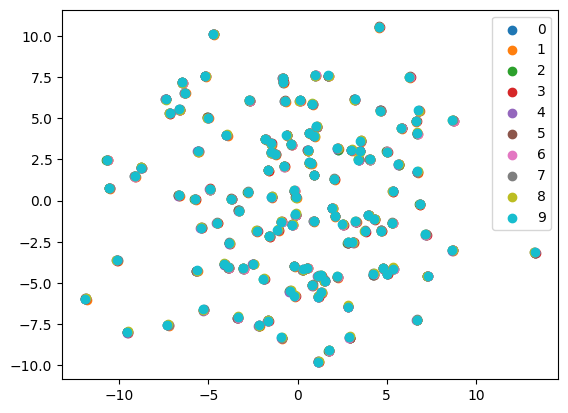

In [90]:
# 同じノイズからの各クラスのノイズの方向
# 毎回 q_sample で 時刻tのノイズを取得

style_scale = 3.
class_scale = 3.
rescaled_phi = .7
target_num = 10
noise_type_str = 'style' # 'style' or 'class'
t_range = (int(0.90*timesteps), int(1.0*timesteps))
pca_path = f"./result/{os.path.basename(model_path).split('.')[0]}_{noise_type_str}_qsample_PCA_time{t_range[0]}-{t_range[1]}.png"

b = 128
# noise_for_q_sample = torch.randn((1, 1, image_size, image_size), device=device)
# noise_for_q_sample = torch.cat([noise_for_q_sample for _ in range(b)], dim=0)
noise_for_q_sample = torch.randn((b, 1, image_size, image_size), device=device)

noise_ave_list = [torch.zeros_like(noise_for_q_sample).cpu().detach().clone() for i in range(target_num)]
for clss in range(target_num):
    if noise_type_str == 'style':
        classes = torch.full((b,), 0, device=device, dtype=torch.long)
        style = torch.full((b,), clss, device=device, dtype=torch.long)
        # class: 0, style: clss の画像のbatchを取得 (b, 1, image_size, image_size)
        imgs = torch.cat([d[clss*26 + 0][0] for i in range(b)]).unsqueeze(1).to(device)

    elif noise_type_str == 'class':
        classes = torch.full((b,), clss, device=device, dtype=torch.long)
        style = torch.full((b,), 0, device=device, dtype=torch.long)
        # class: clss, style: 0 の画像のbatchを取得 (b, 1, image_size, image_size)
        imgs = torch.cat([d[0*26 + clss][0] for i in range(b)]).unsqueeze(1).to(device)

    else:
        raise ValueError(f'noise_type_str must be "style" or "class" but got {noise_type_str}')

    with torch.no_grad():
        for i in tqdm(reversed(range(t_range[0], t_range[1])), desc='sampling loop time step', total=timesteps): # 正規分布
            t = torch.full((b,), i, device=device, dtype=torch.long)
            x = q_sample(imgs, t, noise=noise_for_q_sample)

            if noise_type_str == 'style':
                class_null_logits = model(x, t, classes, style, class_drop_prob=1., style_drop_prob=0.)
                noise_ave_list[clss] += class_null_logits.cpu().detach().clone()
            elif noise_type_str == 'class':
                style_null_logits = model(x, t, classes, style, class_drop_prob=0., style_drop_prob=1.)
                noise_ave_list[clss] += style_null_logits.cpu().detach().clone()
            else:
                raise ValueError(f'noise_type_str must be "style" or "class" but got {noise_type_str}')

        noise_ave_list[clss] = noise_ave_list[clss] / (t_range[1] - t_range[0])

# pca
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(torch.cat(noise_ave_list, dim=0).reshape(b*target_num, -1).numpy())
print(pca.explained_variance_ratio_)
x = X_reduced[:,0]
y = X_reduced[:,1]

for i in range(0, len(X_reduced), b):
    plt.scatter(x[i:i+b], y[i:i+b], label=i//b)
plt.legend()
plt.savefig(pca_path)
plt.show()

## ノイズの波形

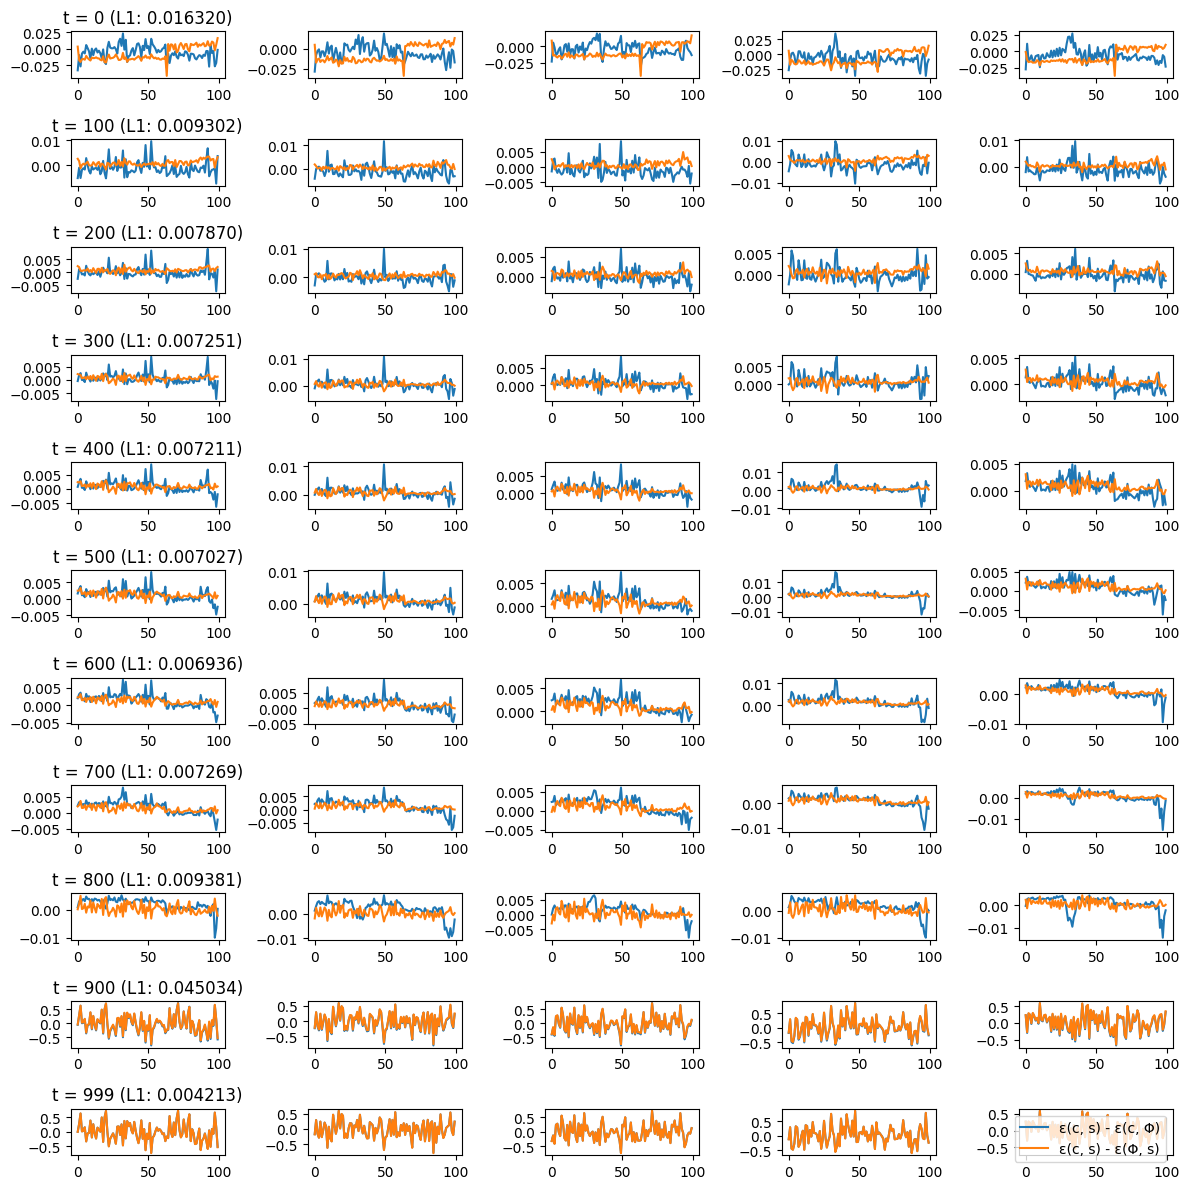

In [5]:
# 同じノイズからの各クラスのノイズの方向
save_path = f"./result/{os.path.basename(model_path).split('.')[0]}_noise_waveform.png"

b = 5
c, s = 0, 0
classes = torch.full((b,), c, device=device, dtype=torch.long)
style = torch.full((b,), s, device=device, dtype=torch.long)

noise_for_q_sample = torch.randn((b, 1, image_size, image_size), device=device)
imgs = torch.cat([d[s*26 + c][0] for _ in range(b)]).unsqueeze(1).to(device)

visualize_dim = 100
fig, ax = plt.subplots(len(range(0, timesteps+1, 100)), b, figsize=(12, 12))
for i, sampling_t in enumerate(range(0, timesteps+1, 100)):
    if sampling_t == timesteps:
        sampling_t -= 1
    t = torch.full((b,), sampling_t, device=device, dtype=torch.long)
    x = q_sample(imgs, t, noise=noise_for_q_sample)

    # ノイズ推定
    with torch.no_grad():
        logits = model(x, t, classes, style, class_drop_prob=0., style_drop_prob=0.)
        class_null_logits = model(x, t, classes, style, class_drop_prob=1., style_drop_prob=0.)
        style_null_logits = model(x, t, classes, style, class_drop_prob=0., style_drop_prob=1.)
        null_logits = model(x, t, classes, style, class_drop_prob=1., style_drop_prob=1.)

    for j in range(b):
        if j % b == 0:
            # loss = nn.L1Loss()(logits - null_logits, style_null_logits - null_logits + class_null_logits - null_logits).cpu().detach().item()
            loss = nn.L1Loss()(style_null_logits - logits, class_null_logits - logits).cpu().detach().item()
            ax[i, j%b].set_title(f't = {sampling_t} (L1: {loss:.6f})')
        # ax[i, j%b].plot(logits[j][0].cpu().detach().reshape(-1)[:visualize_dim], label='ε(c, s)')
        # ax[i, j%b].plot(class_null_logits[j][0].cpu().detach().reshape(-1)[:visualize_dim], label='ε(Φ, s)')
        # ax[i, j%b].plot(style_null_logits[j][0].cpu().detach().reshape(-1)[:visualize_dim], label='ε(c, Φ)')
        # ax[i, j%b].plot(null_logits[j][0].cpu().detach().reshape(-1)[:visualize_dim], label='ε(Φ, Φ)')
        # ax[i, j%b].plot((logits[j][0] - null_logits[j][0]).cpu().detach().reshape(-1)[:visualize_dim], label='ε(c, s) - ε(Φ, Φ)')
        ax[i, j%b].plot((logits[j][0] - style_null_logits[j][0]).cpu().detach().reshape(-1)[:visualize_dim], label='ε(c, s) - ε(c, Φ)')
        ax[i, j%b].plot((logits[j][0] - class_null_logits[j][0]).cpu().detach().reshape(-1)[:visualize_dim], label='ε(c, s) - ε(Φ, s)')
        # ax[i, j%b].plot((class_null_logits[j][0] - null_logits[j][0]).cpu().detach().reshape(-1)[:visualize_dim], label='ε(Φ, s) - ε(Φ, Φ)')
        # ax[i, j%b].plot((style_null_logits[j][0] - null_logits[j][0]).cpu().detach().reshape(-1)[:visualize_dim], label='ε(c, Φ) - ε(Φ, Φ)')
        # ax[i, j%b].plot((style_null_logits[j][0] - null_logits[j][0] + class_null_logits[j][0] - null_logits[j][0])\
        #                         .cpu().detach().reshape(-1)[:visualize_dim], label='ε(c, Φ) - ε(Φ, Φ) + ε(Φ, s) - ε(Φ, Φ)')

plt.tight_layout()
plt.legend()
# plt.savefig(save_path)
plt.show()


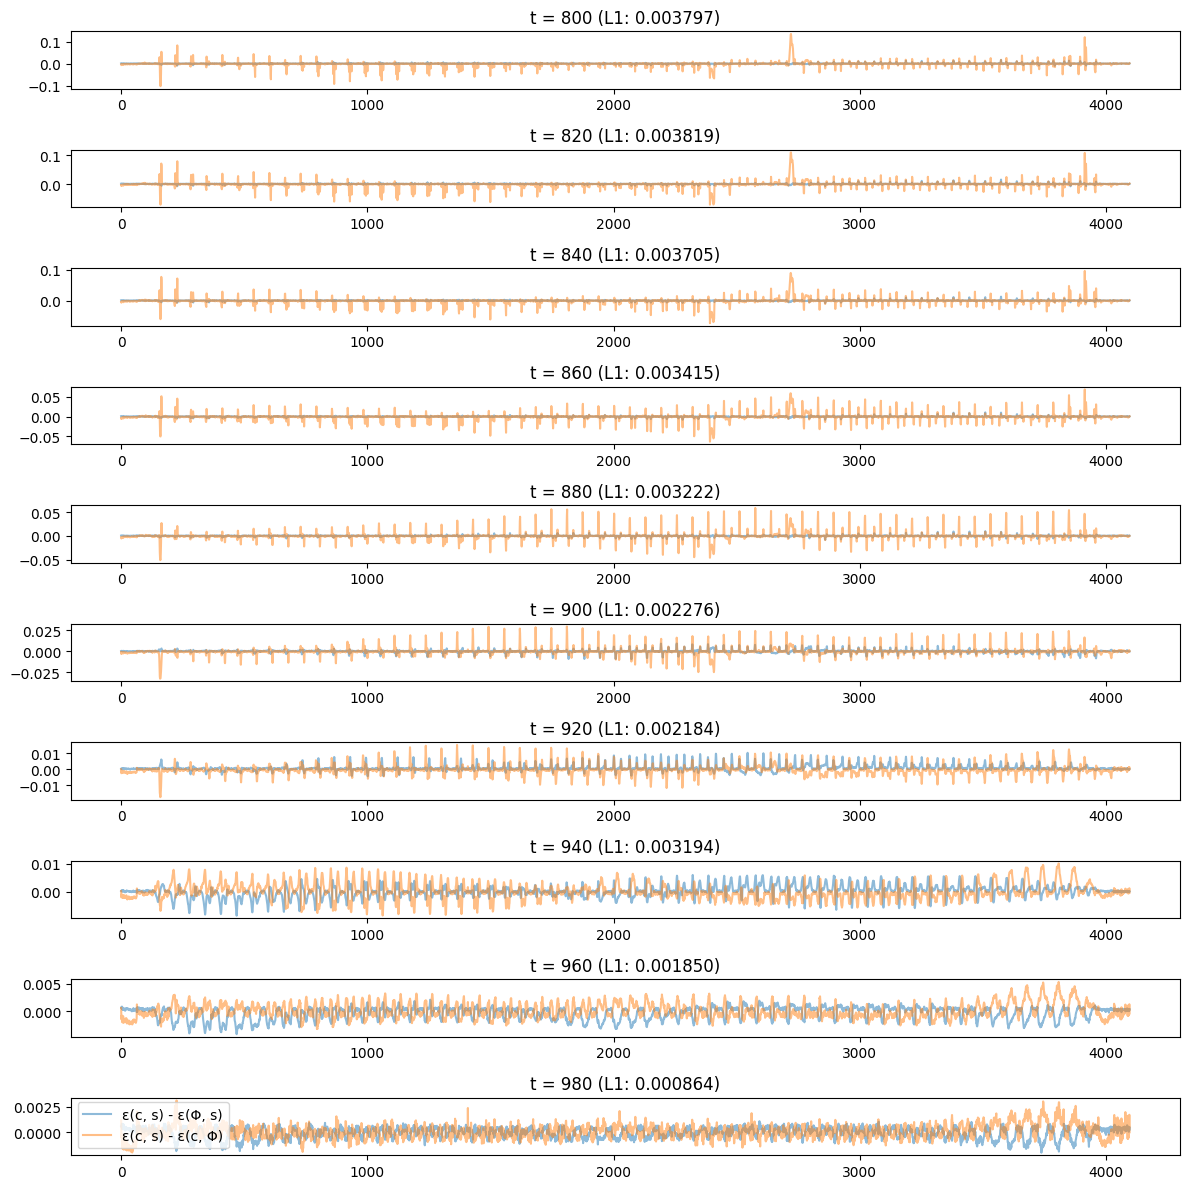

In [39]:
# 同じノイズからの各クラスのノイズの方向
save_path = f"./result/{os.path.basename(model_path).split('.')[0]}_noise_waveform2.png"

b = 1
c, s = 0, 0
classes = torch.full((b,), c, device=device, dtype=torch.long)
style = torch.full((b,), s, device=device, dtype=torch.long)

noise_for_q_sample = torch.randn((b, 1, image_size, image_size), device=device)
imgs = torch.cat([d[s*26 + c][0] for _ in range(b)]).unsqueeze(1).to(device)

visualize_dim = 64*64
visualize_t = [i for i in range(800, timesteps, 20)]
fig, ax = plt.subplots(len(visualize_t), b, figsize=(12, 12))
for i, sampling_t in enumerate(visualize_t):
    if sampling_t == timesteps:
        sampling_t -= 1
    t = torch.full((b,), sampling_t, device=device, dtype=torch.long)
    x = q_sample(imgs, t, noise=noise_for_q_sample)

    # ノイズ推定
    with torch.no_grad():
        logits = model(x, t, classes, style, class_drop_prob=0., style_drop_prob=0.)
        class_null_logits = model(x, t, classes, style, class_drop_prob=1., style_drop_prob=0.)
        style_null_logits = model(x, t, classes, style, class_drop_prob=0., style_drop_prob=1.)
        null_logits = model(x, t, classes, style, class_drop_prob=1., style_drop_prob=1.)

    for j in range(b):
        if j % b == 0:
            # loss = nn.L1Loss()(logits - null_logits, style_null_logits - null_logits + class_null_logits - null_logits).cpu().detach().item()
            loss = nn.L1Loss()(style_null_logits, class_null_logits).cpu().detach().item()
            ax[i].set_title(f't = {sampling_t} (L1: {loss:.6f})')
        # ax[i].plot(logits[j][0].cpu().detach().reshape(-1)[:visualize_dim], label='ε(c, s)', alpha=0.5)
        # ax[i].plot(class_null_logits[j][0].cpu().detach().reshape(-1)[:visualize_dim], label='ε(Φ, s)', alpha=0.5)
        # ax[i].plot(style_null_logits[j][0].cpu().detach().reshape(-1)[:visualize_dim], label='ε(c, Φ)', alpha=0.5)
        # ax[i].plot(null_logits[j][0].cpu().detach().reshape(-1)[:visualize_dim], label='ε(Φ, Φ)', alpha=0.5)
        # ax[i].plot((logits[j][0] - null_logits[j][0]).cpu().detach().reshape(-1)[:visualize_dim], label='ε(c, s) - ε(Φ, Φ)', alpha=0.5)
        ax[i].plot((logits[j][0] - class_null_logits[j][0]).cpu().detach().reshape(-1)[:visualize_dim], label='ε(c, s) - ε(Φ, s)', alpha=0.5)
        ax[i].plot((logits[j][0] - style_null_logits[j][0]).cpu().detach().reshape(-1)[:visualize_dim], label='ε(c, s) - ε(c, Φ)', alpha=0.5)
        # ax[i].plot((class_null_logits[j][0] - null_logits[j][0]).cpu().detach().reshape(-1)[:visualize_dim], label='ε(Φ, s) - ε(Φ, Φ)', alpha=0.5)
        # ax[i].plot((style_null_logits[j][0] - null_logits[j][0]).cpu().detach().reshape(-1)[:visualize_dim], label='ε(c, Φ) - ε(Φ, Φ)', alpha=0.5)
        # ax[i].plot((style_null_logits[j][0] - null_logits[j][0] + class_null_logits[j][0] - null_logits[j][0])\
        #                         .cpu().detach().reshape(-1)[:visualize_dim], label='ε(c, Φ) - ε(Φ, Φ) + ε(Φ, s) - ε(Φ, Φ)', alpha=0.5)

plt.tight_layout()
plt.legend()
# plt.savefig(save_path)
plt.show()


# ノイズの cosine similarity

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


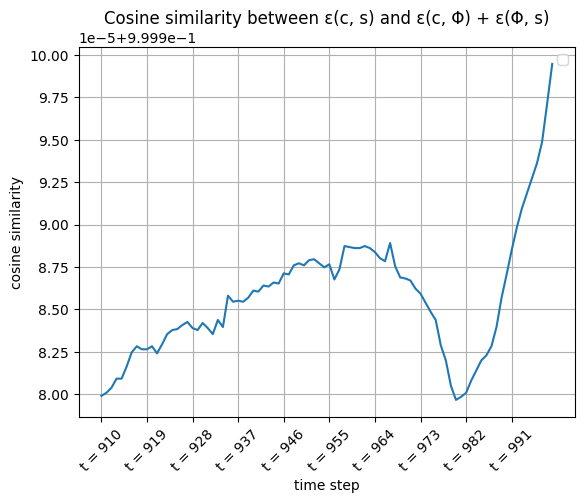

In [162]:
# 同じノイズからの各クラスのノイズの方向

style_scale = 3.
class_scale = 3.
rescaled_phi = .7
t_range = (int(0.91*timesteps), int(1.0*timesteps))
save_path = f"./result/{os.path.basename(model_path).split('.')[0]}_cossim_time{t_range[0]}-{t_range[1]}.png"

# 正規分布からノイズをサンプリング
noise_img = torch.randn_like(torch.zeros((1, 1, image_size, image_size)), device=device)

noise_img = torch.cat([noise_img for _ in range(128)], dim=0)
b = noise_img.shape[0]

cos_sim_list = []

c, s = 0, 0
classes = torch.full((b,), c, device=device, dtype=torch.long)
style = torch.full((b,), s, device=device, dtype=torch.long)
x = noise_img
with torch.no_grad():
    for i in tqdm(reversed(range(t_range[0], timesteps)), desc='sampling loop time step', total=timesteps):
        t = torch.full((b,), i, device=device, dtype=torch.long)

        betas_t = extract(betas, t, x.shape)
        sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
        sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

        # ノイズ推定
        logits = model(x, t, classes, style, class_drop_prob=0., style_drop_prob=0.)
        class_null_logits = model(x, t, classes, style, class_drop_prob=1., style_drop_prob=0.)
        style_null_logits = model(x, t, classes, style, class_drop_prob=0., style_drop_prob=1.)

        # guidance
        # ## disentangle cfg
        # if i >= 900:
        #     scaled_logits = logits + style_scale * class_null_logits + class_scale * style_null_logits
        # else:
        #     scaled_logits = logits + style_scale * (logits - style_null_logits) + class_scale * (logits - class_null_logits)

        ## simple cfg
        scaled_logits = logits + style_scale * (logits - style_null_logits) + class_scale * (logits - class_null_logits)

        # rescale
        std_fn = partial(torch.std, dim = tuple(range(1, scaled_logits.ndim)), keepdim = True)
        rescaled_logits = scaled_logits * (std_fn(logits) / std_fn(scaled_logits))
        pred_noise = rescaled_logits * rescaled_phi + scaled_logits * (1. - rescaled_phi)

        # x_{t-1}を推定
        model_mean = sqrt_recip_alphas_t * (x - betas_t * pred_noise / sqrt_one_minus_alphas_cumprod_t)

        if t_range[0] <= i < t_range[1]:
            cos_sim_list.append(torch.nn.functional.cosine_similarity(logits.reshape(b, -1),
                                                                    (class_null_logits + style_null_logits).reshape(b, -1)).cpu().detach().clone())

        if i == 0:
            x = model_mean
        else:
            posterior_variance_t = extract(posterior_variance, t, x.shape)
            noise = torch.randn_like(x)
            x = model_mean + torch.sqrt(posterior_variance_t) * noise

    cos_sim_list = list(reversed(cos_sim_list))

# cosine similarity
plt.figure()
plt.title("Cosine similarity between ε(c, s) and ε(c, Φ) + ε(Φ, s)")
plt.plot([v.mean() for v in cos_sim_list])
plt.xticks([i for i in range(0, len(cos_sim_list), len(cos_sim_list)//10)],
        [f"t = {i}" for i in range(t_range[0], t_range[1], (t_range[1]-t_range[0])//10)],
        rotation=45)
plt.xlabel('time step')
plt.ylabel('cosine similarity')
plt.grid()
plt.legend()
plt.savefig(f"result/{os.path.basename(model_path).split('.')[0]}_cossim_time{t_range[0]}-{t_range[1]}.png", bbox_inches='tight')
plt.show()

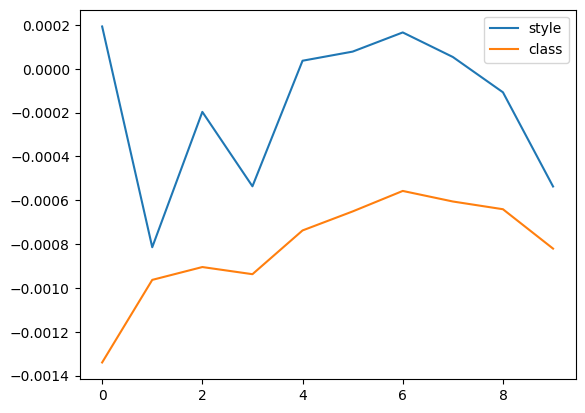

In [164]:
i = 0
dim = 10
# plt.plot(logits.reshape(b, -1)[i].cpu().detach().clone()[:dim], label='style and class')
# plt.plot((class_null_logits + style_null_logits).reshape(b, -1)[i].cpu().detach().clone()[:dim], label='style + class')
# plt.plot((class_null_logits).reshape(b, -1)[i].cpu().detach().clone()[:dim], label='class')
# plt.plot((style_null_logits).reshape(b, -1)[i].cpu().detach().clone()[:dim], label='style')
plt.plot((logits - style_null_logits).reshape(b, -1)[i].cpu().detach().clone()[:dim], label='style')
plt.plot((logits - class_null_logits).reshape(b, -1)[i].cpu().detach().clone()[:dim], label='class')
# for j in range(9):
#     plt.plot((logits - class_null_logits).reshape(b, -1)[i+j+1].cpu().detach().clone()[:dim], label='class')
# for j in range(9):
#     plt.plot((logits - style_null_logits).reshape(b, -1)[i+j+1].cpu().detach().clone()[:dim], label='style')

# null_logits = model()

plt.legend()

# スタイル/クラス埋め込みの可視化

[0.1040342  0.07266873 0.05411684]


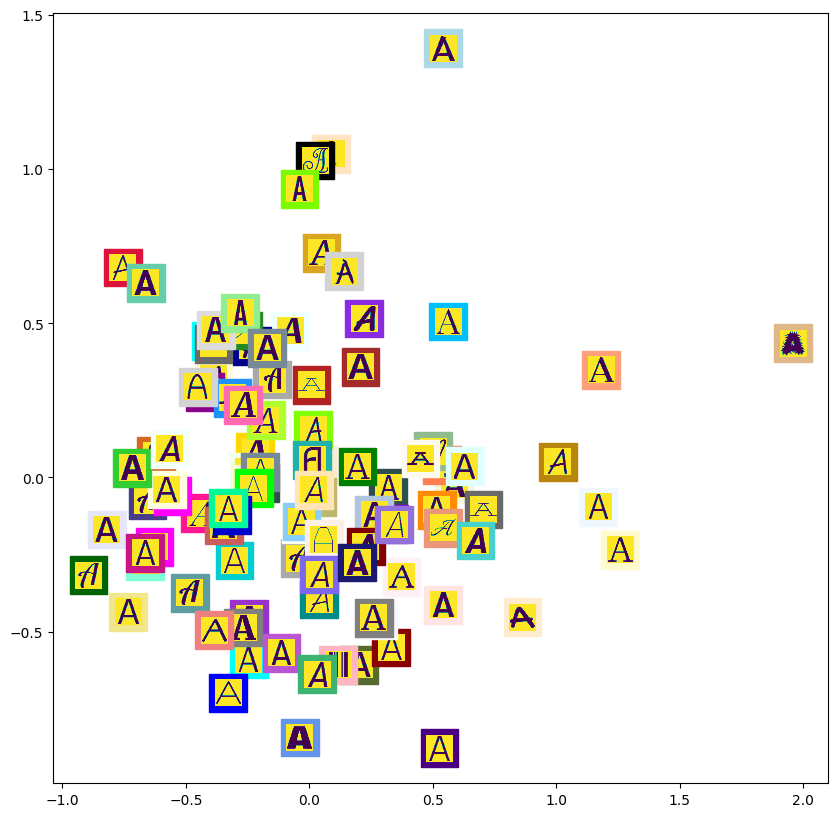

[0.10794472 0.09738914 0.09024908]


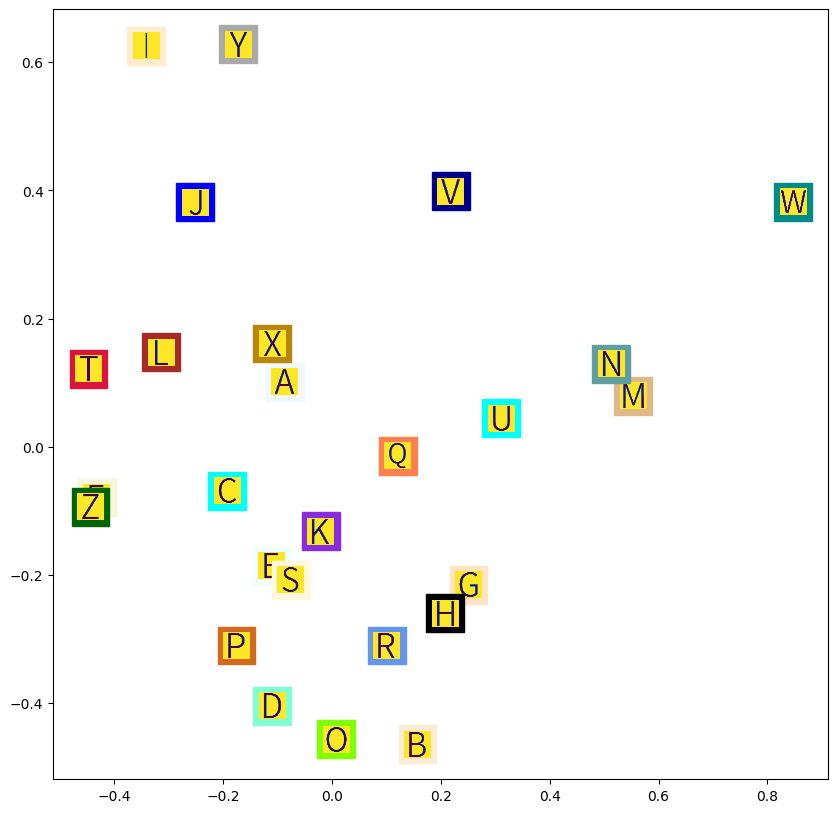

In [24]:
# style emb distribution
b = 100
color = list(matplotlib.colors.CSS4_COLORS.values())
classes = torch.full((b,), 0, device=device, dtype=torch.long)
style, img_list = [], []
for i in range(b):
    img_list.append(d[26*i][0][0])
    style.append(d[26*i][2])
style = torch.tensor(style, device=device, dtype=torch.long)
color_list = [color[s] for s in style]

style_emb = model.style_emb(style)
style_emb = model.style_mlp(style_emb)

pca = PCA(n_components=3)
X_reduced = pca.fit_transform(style_emb.cpu().detach().numpy())
print(pca.explained_variance_ratio_)
x = X_reduced[:,0]
y = X_reduced[:,1]

fig, ax = plt.subplots(figsize=(10,10))
imscatter(x, y, img_list, _ax=ax,zoom=0.3, color=color_list)
ax.plot(x,y,'ko',alpha=0.)
plt.savefig(f"result/{os.path.basename(model_path).split('.')[0]}_style_emb_distribution.png")
plt.show()

# class emb distribution
b = 26
color = list(matplotlib.colors.CSS4_COLORS.values())
style = torch.full((b,), 0, device=device, dtype=torch.long)
classes, img_list = [], []
for i in range(b):
    img_list.append(d[i][0][0])
    classes.append(d[i][1])
classes = torch.tensor(classes, device=device, dtype=torch.long)
color_list = [color[c] for c in classes]

class_emb = model.classes_emb(classes)
class_emb = model.classes_mlp(class_emb)

pca = PCA(n_components=3)
X_reduced = pca.fit_transform(class_emb.cpu().detach().numpy())
print(pca.explained_variance_ratio_)
x = X_reduced[:,0]
y = X_reduced[:,1]

fig, ax = plt.subplots(figsize=(10,10))
imscatter(x, y, img_list, _ax=ax,zoom=0.3, color=color_list)
ax.plot(x,y,'ko',alpha=0.)
plt.savefig(f"result/{os.path.basename(model_path).split('.')[0]}_classes_emb_distribution.png")
plt.show()

# 時刻ごとの diffusion loss

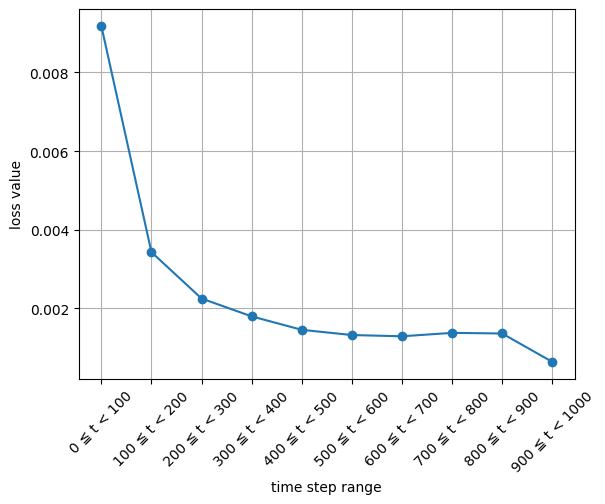

In [5]:
@torch.no_grad()
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x_start.shape)

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

@torch.no_grad()
def p_losses(denoise_model, x_start, t, classes, style, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)

    # ordinal diffusion loss
    predicted_noise = denoise_model(x_noisy, t, classes, style)

    b = x_noisy.size(0)
    diff_loss = F.smooth_l1_loss(noise.view(b, -1), predicted_noise.view(b, -1), reduction='none').mean(dim=1)

    return diff_loss

visualize_t = [i for i in range(100, timesteps+1, 100)]
loss_list = [[] for _ in range(10)]

for batch, classes, style in dataloader:
    batch = batch.to(device)
    classes = classes.to(device)
    style = style.to(device)

    t = torch.randint(0, timesteps, (batch.size(0),), device=device, dtype=torch.long)

    diff_loss = p_losses(model, batch, t, classes, style)

    for i in range(t.size(0)):
        for j in range(10):
            if t[i].item() < visualize_t[j]:
                loss_list[j].append(diff_loss[i].item())
                break

mean_loss_list = [sum(loss_list[i])/len(loss_list[i]) for i in range(10)]

plt.figure()
plt.plot(mean_loss_list, marker='o')
plt.xticks([i for i in range(10)],
        [f"{visualize_t[i]-100} ≦ t < {visualize_t[i]}" for i in range(10)],
        rotation=45)
plt.xlabel('time step range')
plt.ylabel('loss value')
plt.grid()
plt.savefig(f"result/{os.path.basename(model_path).split('.')[0]}_loss_at_different_times.png", bbox_inches='tight')
plt.show()

# 時刻ごとのノイズの大きさ

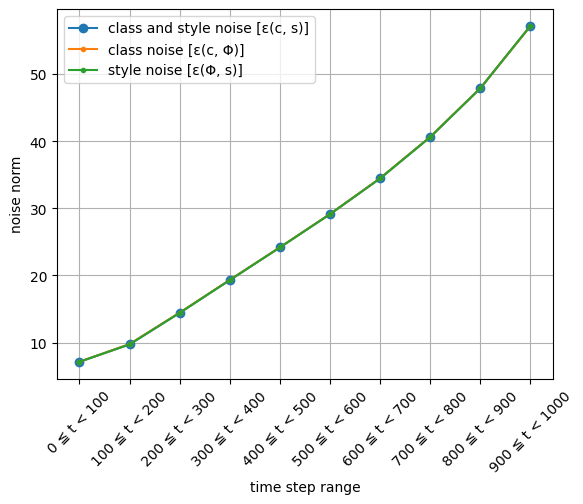

In [6]:
@torch.no_grad()
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x_start.shape)

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

visualize_t = [i for i in range(100, timesteps+1, 100)]
t_cnt = [0 for _ in range(10)]
noise_norm_list = [0. for _ in range(10)]
class_noise_norm_list = [0. for _ in range(10)]
style_noise_norm_list = [0. for _ in range(10)]

with torch.no_grad():
    for batch, classes, style in dataloader:
        batch = batch.to(device)
        classes = classes.to(device)
        style = style.to(device)

        t = torch.randint(0, timesteps, (batch.size(0),), device=device, dtype=torch.long)

        pred_noise = model(batch, t, classes, style, class_drop_prob=0., style_drop_prob=0.)
        class_null_pred_noise = model(batch, t, classes, style, class_drop_prob=1., style_drop_prob=0.)
        style_null_pred_noise = model(batch, t, classes, style, class_drop_prob=0., style_drop_prob=1.)

        noise_norm = torch.linalg.vector_norm(pred_noise.view(t.size(0), -1), dim=1)
        class_noise_norm = torch.linalg.vector_norm(style_null_pred_noise.view(t.size(0), -1), dim=1)
        style_noise_norm = torch.linalg.vector_norm(class_null_pred_noise.view(t.size(0), -1), dim=1)

        for i in range(t.size(0)):
            for j in range(10):
                if t[i].item() < visualize_t[j]:
                    noise_norm_list[j] += noise_norm[i].item()
                    class_noise_norm_list[j] += class_noise_norm[i].item()
                    style_noise_norm_list[j] += style_noise_norm[i].item()
                    t_cnt[j] += 1
                    break

    mean_noise_norm_list = [noise_norm_list[i] / t_cnt[i] for i in range(10)]
    mean_class_noise_norm_list = [class_noise_norm_list[i] / t_cnt[i] for i in range(10)]
    mean_style_noise_norm_list = [style_noise_norm_list[i] / t_cnt[i] for i in range(10)]

plt.figure()
plt.plot(mean_noise_norm_list, marker='o', label='class and style noise [ε(c, s)]')
plt.plot(mean_class_noise_norm_list, marker='.', label='class noise [ε(c, Φ)]')
plt.plot(mean_style_noise_norm_list, marker='.', label='style noise [ε(Φ, s)]')
plt.xticks([i for i in range(10)],
        [f"{visualize_t[i]-100} ≦ t < {visualize_t[i]}" for i in range(10)],
        rotation=45)
plt.xlabel('time step range')
plt.ylabel('noise norm')
plt.grid()
plt.legend()
plt.savefig(f"result/{os.path.basename(model_path).split('.')[0]}_noisenorm_at_different_times.png", bbox_inches='tight')
plt.show()